<a href="https://colab.research.google.com/github/venom1204/QMLHEP/blob/main/task8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ViT(nn.Module):
    def __init__(
        self,
        image_size=28,
        patch_size=7,
        num_classes=10,
        dim=64,
        depth=2,
        heads=4,
        mlp_dim=256,
        channels=1,
    ):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        # Patch embedding
        self.patch_embed = nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size)

        # Class token and positional embeddings
        self.class_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=heads,
                dim_feedforward=mlp_dim,
                activation="gelu",
                batch_first=False,
            ),
            num_layers=depth,
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes),
        )

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)  # (B, dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, dim)

        # Add class token
        class_token = self.class_token.expand(B, -1, -1)
        x = torch.cat([class_token, x], dim=1)  # (B, num_patches + 1, dim)

        # Add positional embeddings
        x += self.pos_embed

        # Transformer expects (seq_len, batch, dim)
        x = x.permute(1, 0, 2)

        # Pass through transformer
        x = self.transformer(x)

        # Extract class token
        x = x[0]  # (B, dim)

        # Classifier
        x = self.mlp_head(x)
        return x

In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.38MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.71MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


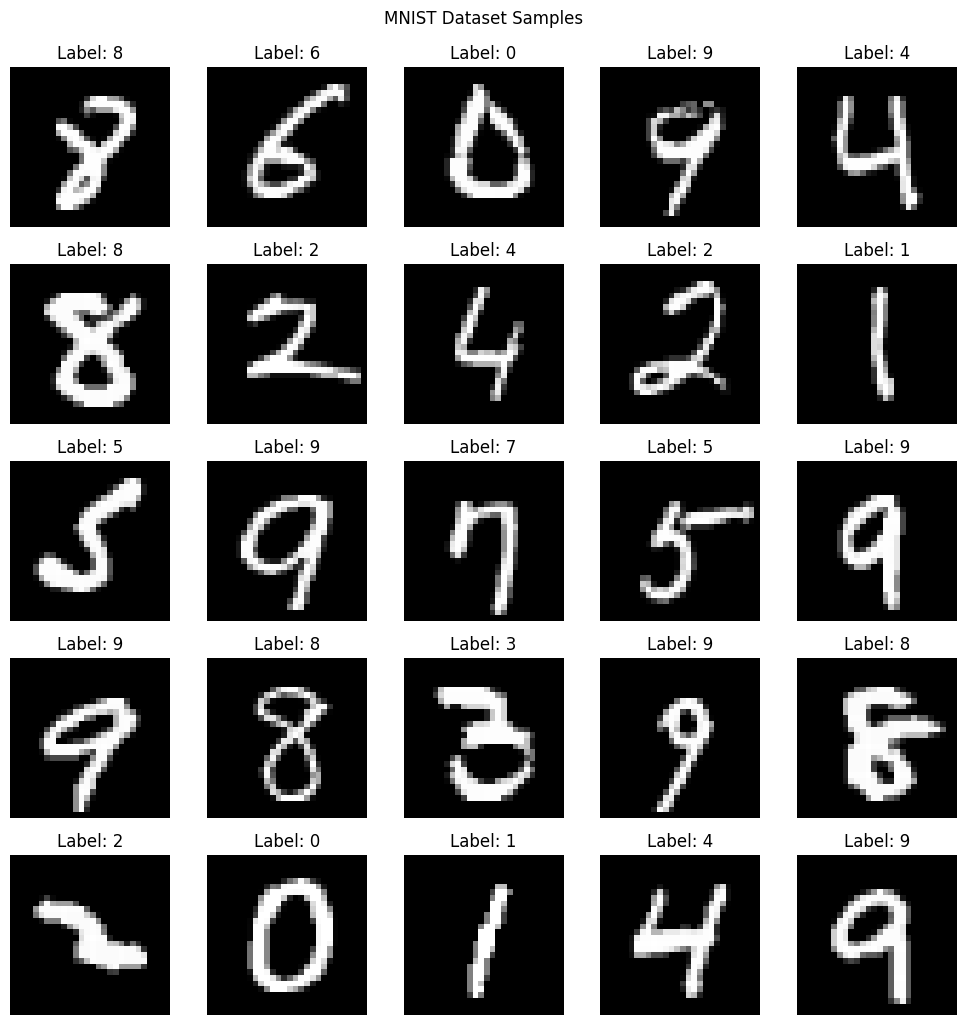

In [ ]:
# Visualize sample MNIST images
def visualize_mnist_samples(dataloader, num_samples=25):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    plt.figure(figsize=(10, 10))
    grid_size = int(num_samples**0.5)
    for i in range(num_samples):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("MNIST Dataset Samples", y=1.02)
    plt.show()

# Display sample images
visualize_mnist_samples(train_loader)


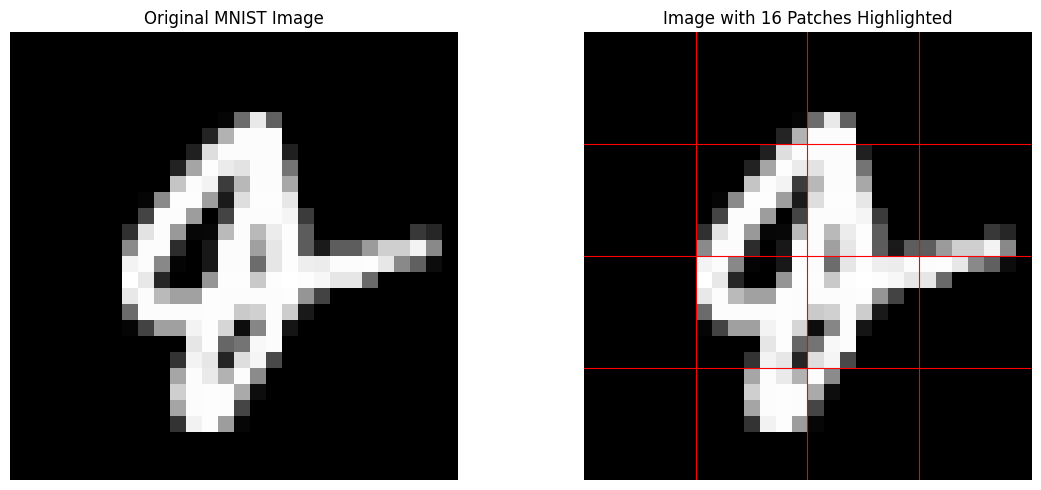

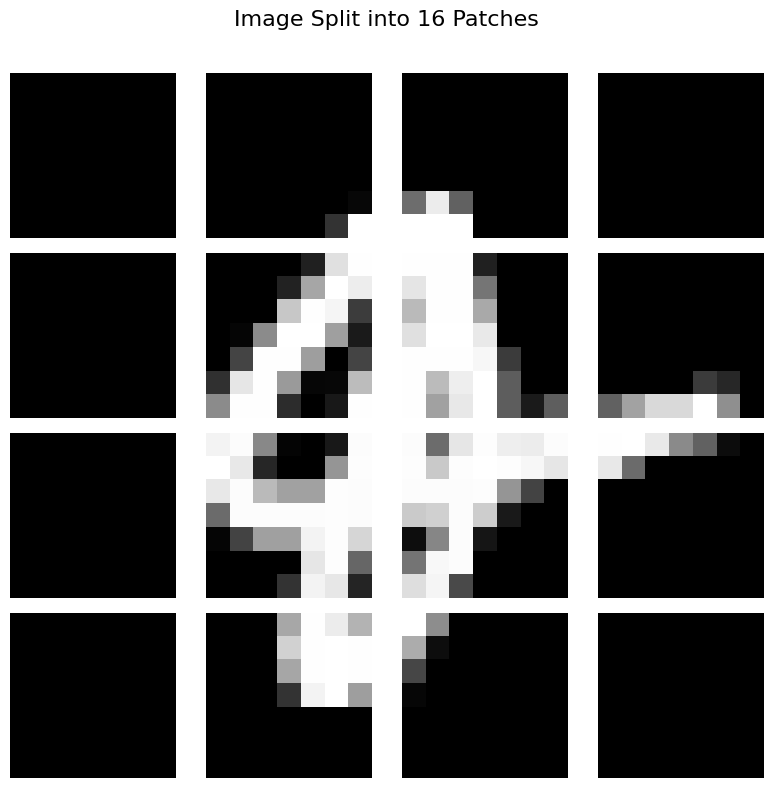

In [ ]:
# Visualize how images are split into patches
def visualize_patches(image, patch_size=7):
    img = image.squeeze().cpu().numpy()
    h, w = img.shape

    # Create a grid for visualization
    fig, axes = plt.subplots(h//patch_size, w//patch_size, figsize=(8, 8))
    fig.suptitle(f"Image Split into {(h//patch_size) * (w//patch_size)} Patches", fontsize=16)

    # Extract and display each patch
    for i in range(h//patch_size):
        for j in range(w//patch_size):
            y_start = i * patch_size
            y_end = (i + 1) * patch_size
            x_start = j * patch_size
            x_end = (j + 1) * patch_size

            patch = img[y_start:y_end, x_start:x_end]
            axes[i, j].imshow(patch, cmap='gray')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Get a sample image
sample_img, _ = next(iter(train_loader))
# Display original and patched version
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img[0].squeeze().cpu().numpy(), cmap='gray')
plt.title("Original MNIST Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sample_img[0].squeeze().cpu().numpy(), cmap='gray')
# Draw grid lines for patches
patch_size = 7
h, w = 28, 28
for i in range(patch_size, h, patch_size):
    plt.axhline(y=i-0.5, color='red', linestyle='-', linewidth=0.8)
for j in range(patch_size, w, patch_size):
    plt.axvline(x=j-0.5, color='red', linestyle='-', linewidth=0.8)
plt.title(f"Image with {(h//patch_size) * (w//patch_size)} Patches Highlighted")
plt.axis('off')
plt.tight_layout()
plt.show()

# Show individual patches
visualize_patches(sample_img[0], patch_size=7)


In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def test(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
# Initialize model, optimizer, and loss
model = ViT().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    print()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10:
Train Loss: 0.7849 | Train Acc: 76.18%
Test Loss: 0.2636 | Test Acc: 92.42%

Epoch 2/10:
Train Loss: 0.2913 | Train Acc: 91.24%
Test Loss: 0.1719 | Test Acc: 94.81%

Epoch 3/10:
Train Loss: 0.2165 | Train Acc: 93.53%
Test Loss: 0.1333 | Test Acc: 95.95%

Epoch 4/10:
Train Loss: 0.1819 | Train Acc: 94.37%
Test Loss: 0.1154 | Test Acc: 96.42%

Epoch 5/10:
Train Loss: 0.1601 | Train Acc: 95.14%
Test Loss: 0.1042 | Test Acc: 96.56%

Epoch 6/10:
Train Loss: 0.1455 | Train Acc: 95.52%
Test Loss: 0.0972 | Test Acc: 96.79%

Epoch 7/10:
Train Loss: 0.1325 | Train Acc: 95.93%
Test Loss: 0.0966 | Test Acc: 96.68%

Epoch 8/10:
Train Loss: 0.1200 | Train Acc: 96.23%
Test Loss: 0.0821 | Test Acc: 97.37%

Epoch 9/10:
Train Loss: 0.1133 | Train Acc: 96.47%
Test Loss: 0.0816 | Test Acc: 97.36%

Epoch 10/10:
Train Loss: 0.1073 | Train Acc: 96.62%
Test Loss: 0.0749 | Test Acc: 97.69%



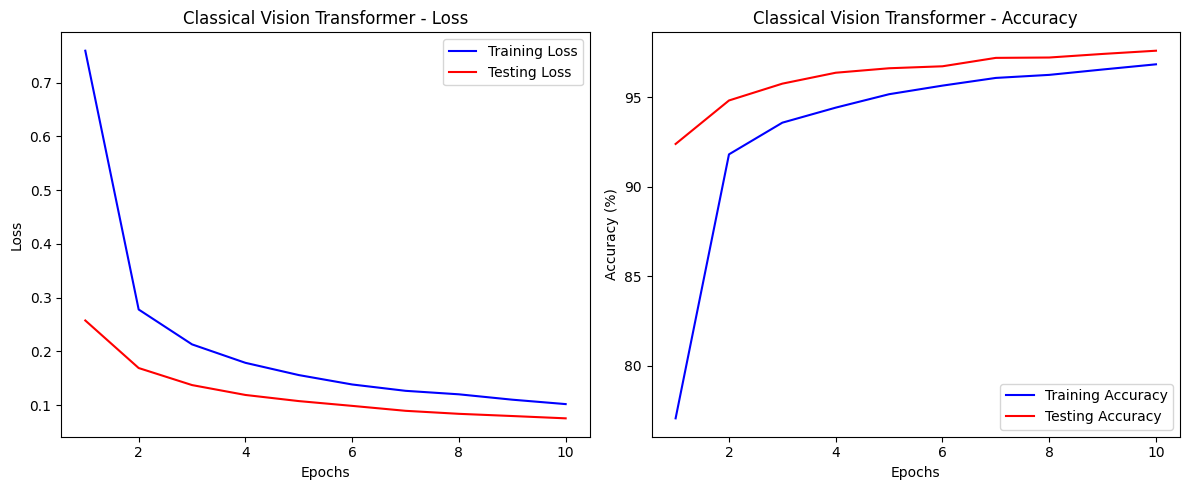

In [ ]:
# Store metrics during training
def plot_training_progress(train_losses, train_accs, test_losses, test_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, test_accs, 'r-', label='Testing Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# For Classical ViT
train_losses = [0.7593, 0.2778, 0.2129, 0.1786, 0.1558, 0.1383, 0.1265, 0.1200, 0.1100, 0.1018]
train_accs = [77.06, 91.81, 93.58, 94.42, 95.17, 95.65, 96.08, 96.25, 96.55, 96.84]
test_losses = [0.2574, 0.1689, 0.1372, 0.1188, 0.1074, 0.0985, 0.0893, 0.0837, 0.0796, 0.0753]
test_accs = [92.39, 94.82, 95.76, 96.37, 96.62, 96.73, 97.20, 97.22, 97.42, 97.60]

plot_training_progress(train_losses, train_accs, test_losses, test_accs, "Classical Vision Transformer")


In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 39.3 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Quantum circuit for processing embeddings (example: 4-qubit circuit)
n_qubits = 4
q_dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(q_dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode classical data into quantum state
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Apply parameterized quantum gates
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes={"weights": (1, n_qubits)})
        # Add a linear layer to adjust the output dimension
        self.fc = nn.Linear(n_qubits, output_dim) # n_qubits = 4, output_dim = num_classes = 10

    def forward(self, x):
        # Reshape input to match quantum circuit expectations
        x = x.view(-1, self.input_dim)
        x = self.qlayer(x)  # Output shape: (batch_size, n_qubits) = (64, 4)

        # Pass through the linear layer to adjust the output dimension
        x = self.fc(x) # x shape becomes: (64, 10)

        # No need for reshape as it's now (batch_size, output_dim)
        return x

In [ ]:
class QViT(nn.Module):
    def __init__(
        self,
        image_size=28,
        patch_size=7,
        num_classes=10,
        dim=64,
        depth=2,
        heads=4,
        channels=1,
    ):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        # Classical components
        self.patch_embed = nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # Replace classical MLP with hybrid quantum-classical layers
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=heads,
                dim_feedforward=dim * 4,  # Reduced for compatibility
                activation="gelu",
                batch_first=False,
            ),
            num_layers=depth,
        )

        # Quantum-classical hybrid head
        self.quantum_proj = nn.Linear(dim, n_qubits)  # Project to quantum circuit input
        self.quantum_layer = QuantumLayer(n_qubits, num_classes)

    def forward(self, x):
        B = x.shape[0]

        # Classical patch embedding
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add class token and positional embeddings
        class_token = self.class_token.expand(B, -1, -1)
        x = torch.cat([class_token, x], dim=1)
        x += self.pos_embed

        # Transformer encoder
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x[0]  # Class token

        # Quantum processing
        x = self.quantum_proj(x)  # (B, n_qubits)
        x = self.quantum_layer(x)
        return x

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Smaller batch for stability
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model
model = QViT(dim=32).to(device)  # Reduced dimension for compatibility
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Training loop
epochs = 10  # Quantum simulations are slow
q_train_losses, q_train_accs, q_test_losses, q_test_accs = [], [], [], [] # Initialize lists to store metrics

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / len(train_dataset)
    train_acc = correct / len(train_dataset)

    # Test
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_dataset)
    test_acc = test_correct / len(test_dataset)

    # Store metrics
    q_train_losses.append(train_loss)
    q_train_accs.append(train_acc)
    q_test_losses.append(test_loss)
    q_test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    print()

Epoch 1/10:
Train Loss: 1.5414 | Train Acc: 37.10%
Test Loss: 1.2453 | Test Acc: 44.38%

Epoch 2/10:
Train Loss: 1.1858 | Train Acc: 51.04%
Test Loss: 1.0620 | Test Acc: 58.43%

Epoch 3/10:
Train Loss: 1.0210 | Train Acc: 63.97%
Test Loss: 0.8970 | Test Acc: 68.89%

Epoch 4/10:
Train Loss: 0.8857 | Train Acc: 68.98%
Test Loss: 0.7934 | Test Acc: 71.19%

Epoch 5/10:
Train Loss: 0.7934 | Train Acc: 74.11%
Test Loss: 0.6928 | Test Acc: 82.61%

Epoch 6/10:
Train Loss: 0.7128 | Train Acc: 79.41%
Test Loss: 0.6256 | Test Acc: 84.05%

Epoch 7/10:
Train Loss: 0.6412 | Train Acc: 82.02%
Test Loss: 0.5681 | Test Acc: 85.57%

Epoch 8/10:
Train Loss: 0.5917 | Train Acc: 84.05%
Test Loss: 0.5098 | Test Acc: 86.01%

Epoch 9/10:
Train Loss: 0.5460 | Train Acc: 87.48%
Test Loss: 0.4780 | Test Acc: 92.26%

Epoch 10/10:
Train Loss: 0.4787 | Train Acc: 91.69%
Test Loss: 0.4062 | Test Acc: 94.85%



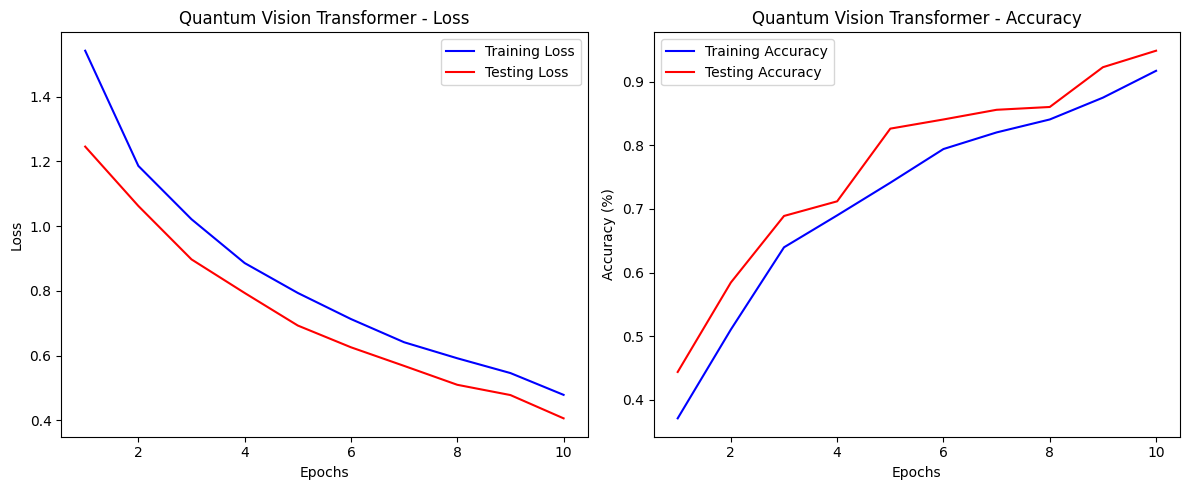

In [ ]:
# Plot for Quantum ViT using the stored metrics
plot_training_progress(q_train_losses, q_train_accs, q_test_losses, q_test_accs, "Quantum Vision Transformer")


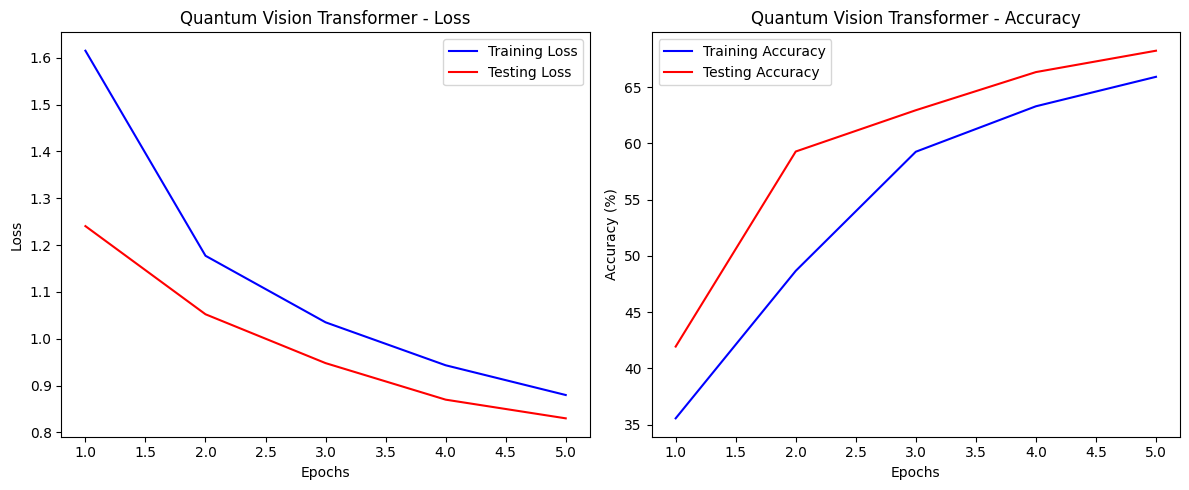

In [ ]:
# Store metrics during training
def plot_training_progress(train_losses, train_accs, test_losses, test_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, test_accs, 'r-', label='Testing Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# For Quantum ViT
q_train_losses = [1.6150, 1.1772, 1.0351, 0.9434, 0.8799]
q_train_accs = [35.56, 48.67, 59.26, 63.30, 65.92]
q_test_losses = [1.2405, 1.0523, 0.9480, 0.8700, 0.8301]
q_test_accs = [41.94, 59.28, 62.95, 66.34, 68.24]

plot_training_progress(q_train_losses, q_train_accs, q_test_losses, q_test_accs, "Quantum Vision Transformer")
